In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle
from copy import deepcopy

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mcmodels.core.utils import get_ccf_data

from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists,CrossvalNW

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structures.npy')
major_structure_ids = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structure_ids.npy')
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_leaves_v3.npy')

annotation/ccf_2017


In [14]:
#print(connectivity_data.structure_datas[512].experiment_datas[120493315].projection_vec.shape)
#print(connectivity_data.structure_datas[512].experiment_datas[120493315].injection_vec.shape)
#print(connectivity_data.structure_datas[512].experiment_datas[120493315].injection_signal.shape)
experiment_id = 120493315
injection_signal = cache.get_injection_density(experiment_id)[0]
injection_fraction = cache.get_injection_fraction(experiment_id)[0]
projection_signal = cache.get_projection_density(experiment_id)[0]
# injection_signal.argsort()
# injection_signal[injection_signal.argsort()[:30]]
# plt.scatter(projection_signal, injection_signal / injection_fraction)

In [15]:
#plt.scatter(injection_signal[asdf], projection_signal[asdf])
#help(cache.get_data_mask)

In [16]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(major_structure_ids)

connectivity_data.ai_map = ai_map
connectivity_data.get_crelines(data_info)
connectivity_data.get_summarystructures(data_info)
connectivity_data.summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)
connectivity_data.leafs = leafs

sid0 = list(connectivity_data.structure_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
targ_ord = ontological_order_leaves
source_ord = ontological_order_leaves
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
#ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)
connectivity_data.get_regionalized_normalized_data(source_ord, ipsi_targetkey, contra_targetkey)

frac_learn = np.ones(12)

#get surfaces summary
#sumsurf NW

512
703
1089
1097
315
313
354
698
771
803
477
549


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:221: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:221: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)


In [17]:
connectivity_data.sum2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.get_cresum_combos()
connectivity_data.get_creleaf_combos()
connectivity_data.cresum2_index_matrices = get_indices_2ormore(connectivity_data.cresum_combos)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.cre2_index_matrices = get_indices_2ormore(crelines)
connectivity_data.major2_index_matrices = {}
for sid in major_structure_ids:
     connectivity_data.major2_index_matrices[sid] =  np.expand_dims(np.ones(crelines[sid].shape),0)

In [18]:
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_sum = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m])
    connectivity_data.structure_datas[sid].smoothed_losses_sum = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_sum,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_sum.cre_distances_cv)



/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.

In [19]:
#get surfaces leaf
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_leaf = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])
    connectivity_data.structure_datas[sid].smoothed_losses_leaf = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_leaf,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_leaf.cre_distances_cv)
    

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.

In [20]:
#what are the indices that have both 2 in the same leaf, and 2 of the same cre in the sum
connectivity_data.cresum2_leaf2_index_matrices = deepcopy(connectivity_data.cresum2_index_matrices)
for sid in major_structure_ids:
    included_leaf2 =  connectivity_data.leaf2_index_matrices[sid].sum(axis = 0)
    included_cresum2 = connectivity_data.cresum2_index_matrices[sid].sum(axis = 0)
    keepers = np.intersect1d( np.where(included_leaf2 == 1)[0], np.where(included_cresum2 == 1)[0])
    #print(len(keepers))
    setdiff = np.setdiff1d(list(range(connectivity_data.leaf2_index_matrices[sid].shape[1])), keepers)
    connectivity_data.cresum2_leaf2_index_matrices[sid][:,setdiff] = 0
    

In [21]:
connectivity_data.cresum2_evalindices = get_eval_indices(connectivity_data.cresum2_index_matrices)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)
connectivity_data.cresum2_leaf2_evalindices = get_eval_indices(connectivity_data.cresum2_leaf2_index_matrices)


gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
reg_proj_norm = {sid: connectivity_data.structure_datas[sid].reg_proj_norm for sid in major_structure_ids}
sum2_index_matrices = {sid: connectivity_data.sum2_index_matrices[sid] for sid in major_structure_ids} 
cresum2_evalindices = {sid: connectivity_data.cresum2_evalindices[sid] for sid in major_structure_ids} 
cresum2_leaf2_evalindices = {sid: connectivity_data.cresum2_leaf2_evalindices[sid] for sid in major_structure_ids} 
creleaf2_evalindices = {sid: connectivity_data.creleaf2_evalindices[sid] for sid in major_structure_ids} 
crelines = {sid: connectivity_data.creline[sid] for sid in major_structure_ids}
#look at visp6a prediction accuracy
#lets just make the eval plots

In [22]:
sum2_index_matrices = {sid: connectivity_data.sum2_index_matrices[sid] for sid in major_structure_ids} 
distances = {sid: connectivity_data.structure_datas[sid].smoothed_losses_sum for sid in major_structure_ids}
twostage_sum_creleaf2 = CrossvalNW(reg_proj_norm, distances, sum2_index_matrices, creleaf2_evalindices,gammas)
twostage_sum_creleaf2.gammas = gammas #ds
twostage_sum_creleaf2.predictions = twostage_sum_creleaf2.get_predictions()
twostage_sum_creleaf2.get_results_loocv()
twostage_sum_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

In [25]:
twostage_sum_creleaf2.meanloss_weighted

array([0.09166686, 0.75822031, 0.13171331, 0.33131825, 0.2295201 ,
       0.21677507, 0.19801086, 0.13622945, 0.30690343, 0.19741817,
       0.1255011 , 0.36522673])

In [10]:
surfaces = {}
for m in range(len(major_structure_ids)):
    sid = major_structure_ids[m]
    surfaces[sid ] = connectivity_data.structure_datas[sid].loss_surface_cv_sum
    surfaces[sid ].gamma = twostage_sum_creleaf2.bestgamma_weighted[m]
    
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/ELsum_surface_0427_leafleaf2.pickle', 'wb') as handle:
    pickle.dump(surfaces, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
distances = {sid: connectivity_data.structure_datas[sid].smoothed_losses_leaf for sid in major_structure_ids}
twostage_leaf_creleaf2 = CrossvalNW(reg_proj_norm, distances, leaf2_index_matrices, creleaf2_evalindices,gammas)
twostage_leaf_creleaf2.gammas = gammas #ds
twostage_leaf_creleaf2.predictions = twostage_leaf_creleaf2.get_predictions()
twostage_leaf_creleaf2.get_results_loocv()
twostage_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

In [28]:
twostage_leaf_creleaf2.meanloss_weighted

array([0.06843855, 0.75822031, 0.1487879 , 0.33131825, 0.24676055,
       0.19522774, 0.19801086, 0.13622945, 0.30690343, 0.19741817,
       0.1255011 , 0.36620737])

In [27]:
surfaces = {}
for m in range(len(major_structure_ids)):
    sid = major_structure_ids[m]
    surfaces[sid ] = connectivity_data.structure_datas[sid].loss_surface_cv_leaf
    surfaces[sid ].gamma = twostage_leaf_creleaf2.bestgamma_weighted[m]
    


In [37]:
gammaids = np.zeros(12)
for m in range(12):
    gammaids[m] = np.where(gammas == twostage_leaf_creleaf2.bestgamma_weighted[m])[0]
gammaids = np.asarray(gammaids , dtype = int)

In [ ]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/ELleaf_surface_0427_leafleaf2.pickle', 'wb') as handle:
    pickle.dump(surfaces, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:

#     def get_threshold_correlations(cvexp, threshes, sel_gammas):

#         self = cvexp
#         models = self.models
#         nmodels = len(models)
#         predictions = self.predictions
#         data = self.data
#         nt = len(threshes)
        
#         aboves = {}#np.zeros((nmodels, nt))
#         belows = {}#np.zeros((nmodels, nt))
#         w_ab= {}#np.zeros((nmodels, nt))
#         w_be = {}#np.zeros((nmodels, nt))
#         eval_indices = self.eval_indices
        
#         for m in range(nmodels):
#             sid = models[m]
#             npt = len(eval_indices[sid])
#             aboves[sid] = np.zeros((nt, npt))
#             belows[sid] = np.zeros((nt, npt))
#             w_ab[sid] = np.zeros((nt, npt))
#             w_be[sid] = np.zeros((nt, npt))
            
#             for i in range(npt):
#                 ind = eval_indices[sid][i]
#                 for t in range(len(threshes)):
#                     #print(sel_gammas[m])
#                     #print(predictions[sid])
#                     #print(threshes[t])
#                     #print(predictions[sid][sel_gammas[m]][0])
#                     #print(predictions[sid][sel_gammas[m]])
#                     above_inds = np.where(predictions[sid][sel_gammas[m]][ind] > threshes[t])[0]
#                     below_inds = np.where(predictions[sid][sel_gammas[m]][ind] <= threshes[t])[0]
#                     #print(len(above_inds), len(below_inds))
                    
#                     w_ab[sid][t,i] = len(above_inds) / len(predictions[sid][sel_gammas[m]][0])
#                     w_be[sid][t,i] = len(below_inds) / len(predictions[sid][sel_gammas[m]][0])
#                     #print(len(inds), len(indsn1))
# #                    aboves[sid][t,i] = get_kendall_zero(predictions[sid][sel_gammas[m]][ind][above_inds], data[sid][ind][above_inds])
# #                    belows[sid][t,i] = get_kendall_zero(predictions[sid][sel_gammas[m]][ind][below_inds], data[sid][ind][below_inds])

#         return(w_ab, w_be)

In [50]:
threshes = np.asarray([0,1e-9,1e-8,1e-7,1e-6,1e-5, 1e-4, 1e-3,1e-2])
sel_gammas = twostage_leaf_creleaf2.bestgamma_weighted
#proportion_abovethresh, proportion_belowthresh  = get_threshold_correlations(twostage_leaf_creleaf2, threshes, gammaids)

In [51]:
self = twostage_leaf_creleaf2
models = self.models
nmodels = len(models)
predictions = self.predictions
data = self.data
nt = len(threshes)
eval_indices = self.eval_indices
results_n1 = np.zeros((nmodels,nt))
results_p1 = np.zeros((nmodels,nt))
bestfpfn = np.zeros(nmodels)
npts = np.zeros(nmodels)
#fpfn_proportion = np.zeros((nmodels,nt))
for m in range(nmodels):
    sid = models[m]
    inds = eval_indices[sid]
    npt = len(eval_indices[sid])
    npts[m] = npt
#     aboves[sid] = np.zeros((nt, npt))
#     belows[sid] = np.zeros((nt, npt))
#     w_ab[sid] = np.zeros((nt, npt))
#     w_be[sid] = np.zeros((nt, npt))
    
    #results_p1 = np.zeros(nt)
    for c in range(nt):
        output = np.ones(data[sid][inds].shape)
        baseline = np.ones(data[sid][inds].shape)
        #pred_mat = loocvpredictions[315][5].copy()
        zeroind_data = np.asarray(np.where(data[sid][inds] == 0.))
        zeroind_pred = np.asarray(np.where(predictions[sid][gammaids[m]][inds]  <= threshes[c]))
        output[tuple(zeroind_pred)] = 0.
        baseline[tuple(zeroind_data)] = 0.
        diff = output - baseline
        # results_p1 is how many false positives
        # results_n1 is how many false negatives
        results_n1[m,c] = np.where(diff == -1)[0].shape[0]
        results_p1[m,c] = np.where(diff == 1)[0].shape[0]
    
    bestfpfn[m] = np.abs(results_p1[m] - results_n1[m]).argmin()
    
fpfn_proportion = np.abs(results_p1 - results_n1) / (np.expand_dims(npts,1)*data[512].shape[1])
fpfn_proportion= pd.DataFrame(fpfn_proportion, columns=threshes, index=major_structures)
    #return(fpfn_proportion)
    #return(results_n1)

In [54]:
combpos = fpfn_proportion + fpfn_proportion

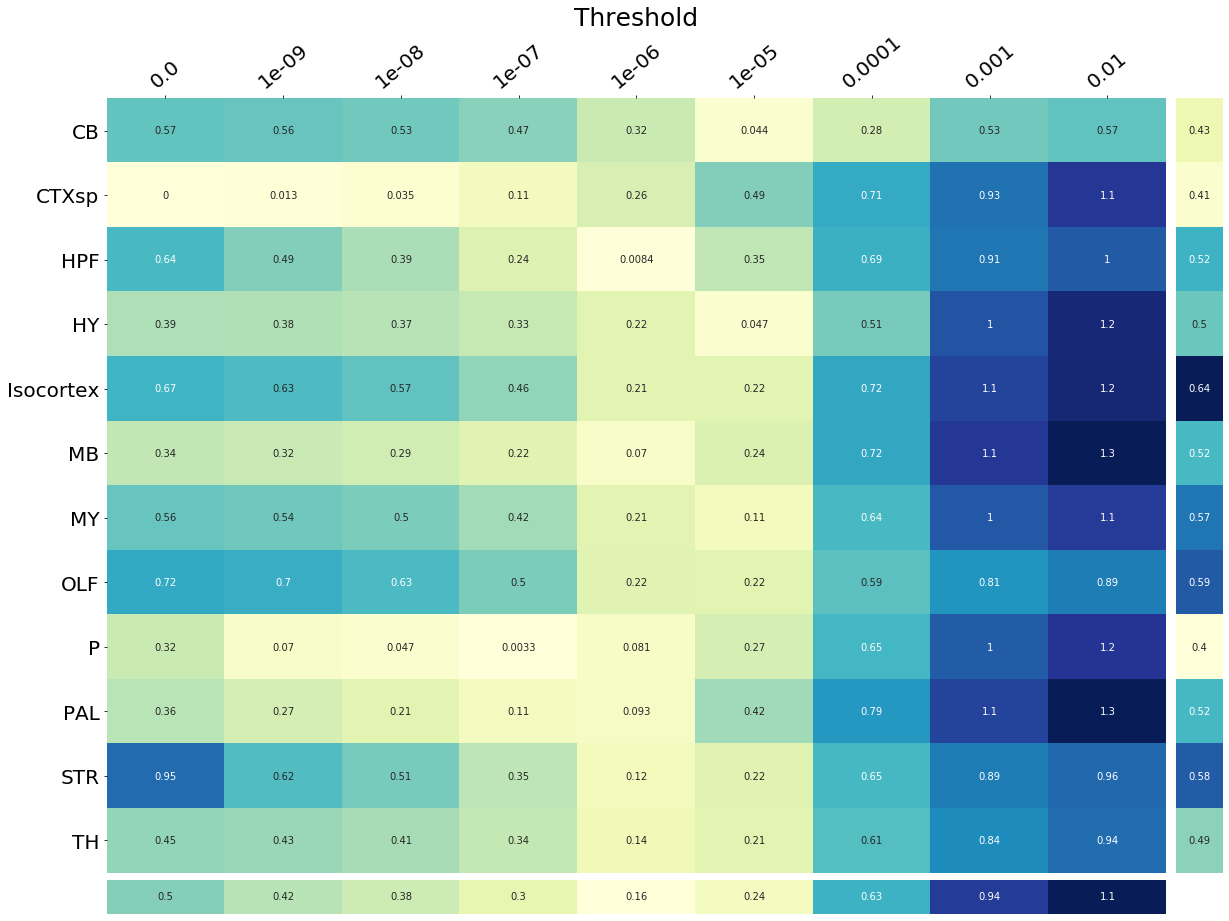

In [126]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)
#ax4 = plt.subplot2grid((20,20), (19,19), colspan=19, rowspan=1)
#ax4.set_title('asdf')
#ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)
#mask = np.zeros_like(combpos)
#mask[np.tril_indices_from(mask)] = True

sns.heatmap(combpos, ax = ax1, annot=True, cmap="YlGnBu", linecolor='b', cbar = False)
ax1.set_title("Threshold", fontsize = 25)
#ax1.ax_cbar.set_position([1.0,0.4,.1,.1])
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize = 20)
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize = 20, rotation = 0)
#ax1.set_xlabel('Threshold')
ax1.xaxis.tick_top()
ax1.set_xticklabels(combpos.columns,rotation=40)

sns.heatmap((pd.DataFrame(combpos.mean(axis=0))).transpose(), ax=ax2,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
sns.heatmap(pd.DataFrame(combpos.mean(axis=1)), ax=ax3,  annot=True, cmap="YlGnBu", cbar = False,
            xticklabels=False, yticklabels=False)
fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/Threshold', pad_inches = 0)

#plt.suptitle('False negatives + false positives', fontsize = 40)

In [30]:
creleaf2_index_matrices = {sid: connectivity_data.creleaf2_index_matrices[sid] for sid in major_structure_ids} 
pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    
distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_creleaf_creleaf2 = CrossvalNW(reg_proj_norm, distances,creleaf2_index_matrices, creleaf2_evalindices,gammas)
nw_creleaf_creleaf2.gammas = gammas# ds
nw_creleaf_creleaf2.predictions = nw_creleaf_creleaf2.get_predictions()
nw_creleaf_creleaf2.get_results_loocv()
nw_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [31]:
nw_creleaf_creleaf2.meanloss_weighted

array([0.06203923, 0.75822031, 0.17073421, 0.3812252 , 0.25764741,
       0.20105572, 0.26104588, 0.18411434, 0.30937673, 0.22011156,
       0.12924188, 0.63420233])